# Introduction

We intend to produce a model based on BERT to infer capacity of predicting if a tweet can be categorized as an Alert disaster tweet or not.

Some kernels have already implemented such models :

* egortrushin/nlp-with-disaster-tweets-roberta-using-pytorch         NLP with Disaster Tweets: RoBERTa using PyTorch     Egor Trushin

* ashishsingh226/disaster-tweet-classification-using-distil-bert     Disaster Tweet Classification using Distil Bert     AshishSingh226


In a perspective to contribute to the community, we propose another implementation for BERT with fast-bert api on PyTorch.

The objective is to try achieve a high accuracy scoring by :

* implementing most appropriate pretrained model
* fine tuning hyperparameters
* fine tune optimizer  

# Imports

In [26]:
!pip install fast-bert

In [27]:
!pip install emoji

In [28]:
import pandas as pd
pd.options.mode.chained_assignment = None

import torch
from fast_bert.data_cls import BertDataBunch
from fast_bert.learner_cls import BertLearner
from fast_bert.data_lm import BertLMDataBunch
from fast_bert.learner_lm import BertLMLearner

from fast_bert.metrics import fbeta, roc_auc, accuracy
from fast_bert.prediction import BertClassificationPredictor
from pathlib import Path
import pandas as pd
import logging
import os
import pickle
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
import re
import emoji

import warnings
warnings.filterwarnings('ignore')

logger = logging.getLogger()
device_cuda = torch.device("cuda")

# Datasets loading

In [29]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv',sep=",")

In [30]:
test_data = pd.read_csv('../input/nlp-getting-started/test.csv',sep=",")

In [31]:
print("Total rows in train data: ",train_data.shape[0])
print("Total columns in train data: ",train_data.shape[1])
print("-"*30)
print("Total rows in test data: ",test_data.shape[0])
print("Total columns in test data: ",test_data.shape[1])

Total rows in train data:  7613
Total columns in train data:  5
------------------------------
Total rows in test data:  3263
Total columns in test data:  4


In [32]:
train_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [33]:
test_data.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [34]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Data Exploration & Cleaning

In [35]:
print(train_data.isnull().sum())
print("-"*30)
print(test_data.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
------------------------------
id             0
keyword       26
location    1105
text           0
dtype: int64


We drop keyword and location columns as too many Nan and not really useful in the perspective of this classification objective.

In [36]:
train_data.groupby(train_data.target).count().text

target
0    4342
1    3271
Name: text, dtype: int64

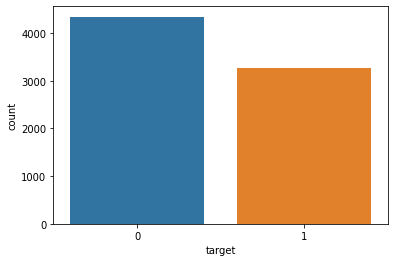

In [37]:
sns.countplot(train_data.target,data = train_data)
plt.show()

The dataset is quite balanced between the 2 classes which is ok for our classification purpose.

### Dropping keyword and location columns

In [38]:
train_data = train_data.drop(['keyword','location'], axis = 1)
test_data = test_data.drop(['keyword','location'], axis = 1)

In [39]:
train_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


# Preprocessing 

We need to remove superfluous data like url, emoji

In [40]:
def cleanTweet(txt):
    txt = re.sub(r'@[A-Za-z0-9_]+','',txt)
    txt = re.sub(r'#','',txt)
    txt = re.sub(r'RT : ','',txt)
    txt = re.sub(r'\n','',txt)
    # to remove emojis
    txt = re.sub(emoji.get_emoji_regexp(), r"", txt)
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+','',txt)
    txt = re.sub(r"https?://\S+|www\.\S+","",txt)
    txt = re.sub(r"<.*?>","",txt)
    return txt  

def make_Lower(text):
    return str.lower(text)

In [41]:
train_data.text = train_data.text.apply(cleanTweet)
train_data.text = train_data.text.apply(make_Lower)

test_data.text = test_data.text.apply(cleanTweet)
test_data.text = test_data.text.apply(make_Lower)

We save these preprocessed datasets as they will be model input from disk resources

In [42]:
train_data.to_csv('train_preprocessed.csv', index=False) 
test_data.to_csv('test_preprocessed.csv', index=False) 

# Model

### Define main paths

In [43]:
DATA_PATH = Path('data/')
LABEL_PATH = Path('data/')
MODEL_PATH=Path('models/')
LOG_PATH=Path('logs/')
MODEL_PATH.mkdir(exist_ok=True)
DATA_PATH.mkdir(exist_ok=True)
LOG_PATH.mkdir(exist_ok=True)

### Prepare train and validation sets

In [46]:
val_set = train_data.sample(frac=0.2, replace=False, random_state=42)
train_set = train_data.drop(index = val_set.index)
print('Number of tweets in val_set:',len(val_set))
print('Number of tweets in train_set:', len(train_set))
val_set.to_csv(str(DATA_PATH) + '/val_set.csv')
train_set.to_csv(str(DATA_PATH) + '/train_set.csv')

Number of tweets in val_set: 1523
Number of tweets in train_set: 6090


In [48]:
labels = train_data.columns[2:].to_list()
with open(str(LABEL_PATH) + '/labels.txt', 'w') as f:
    for i in labels:
        f.write(i + "\n")

target


In [49]:
all_texts = train_data['text'].to_list()
print('Number of tweets:', len(all_texts))

Number of tweets: 7613


### Create LMDataBunch

In this phase we first fine tune BERT model to our corpus.

We first need to instanciate data bunches for batching learning phase.

Note here we use 'bert-base-uncased' tokenizer defined on pretrained BERT model. 

In [54]:
t0 = time()
databunch_lm = BertLMDataBunch.from_raw_corpus(
                    data_dir=Path(DATA_PATH),
                    text_list=all_texts,
                    tokenizer='bert-base-uncased',
                    batch_size_per_gpu=16,
                    max_seq_length=512,
                    multi_gpu=False,
                    model_type='bert',
                    logger=logger)
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')


total time for operation: 0.7282178401947021s


### Create LMLearner

We instanciate a learner for fine tuning the model based on pretrained bert model.

Here we choose simple 'bert' model, and accuracy as metric of learning process.

In [56]:
t0 = time()
metrics = []
metrics.append({'name': 'accuracy', 'function': accuracy})
lm_learner = BertLMLearner.from_pretrained_model(
                            dataBunch=databunch_lm,
                            pretrained_path='bert-base-uncased',
                            output_dir=Path(MODEL_PATH),
                            metrics=metrics,
                            device=device_cuda,
                            logger=logger,
                            multi_gpu=False,
                            logging_steps=50,
                            fp16_opt_level="O2")
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

AssertionError: Torch not compiled with CUDA enabled

### Find the optimal learning rate

Based on integrated Bert Adam optimizer we try to fit the most suitable learning rate for our fine-tuning. 

This step is important as it is fine tuning, we don't want to retrain the whole model but be as accurate as possible.

In [ ]:
lm_learner.lr_find(start_lr=1e-5,optimizer_type='adamw')

In [ ]:
lm_learner.plot()

### Fitting the learner

We choose AdamW with warmup_cosine that variates learning rate from its original value to 0 with cosine periodicity.

In [ ]:

lm_learner.fit(epochs=10,
            lr=1e-4,
            validate=True,
            schedule_type="warmup_cosine",
            optimizer_type="adamw")

In [ ]:
from time import time
t0 = time()
lm_learner.validate()
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

In [ ]:
t0 = time()
lm_learner.save_model()
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

### Create databunch for our classification

In [ ]:
labels_col = ['target']

In [ ]:
t0 = time()
databunch = BertDataBunch(Path(DATA_PATH), Path(LABEL_PATH),
                          tokenizer='bert-base-uncased',
                          train_file='train_set.csv',
                          val_file='val_set.csv',
                          label_file='labels.txt',
                          text_col='text',
                          label_col=labels_col,
                          batch_size_per_gpu=16,
                          max_seq_length=512,
                          multi_gpu=False,
                          multi_label=True,
                          model_type='bert')
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

### Création de Learner pour la classification

In [ ]:
metrics = []
metrics.append({'name': 'accuracy', 'function': accuracy})
OUTPUT_DIR = MODEL_PATH + '/finetuned_model'
WGTS_PATH = MODEL_PATH + '/model_out/pytorch_model.bin'

In [ ]:
t0 = time()
cl_learner = BertLearner.from_pretrained_model(
                        databunch,
                        pretrained_path=MODEL_PATH + '/model_out',
                        metrics=metrics,
                        device=device_cuda,
                        logger=logger,
                        output_dir=Path(OUTPUT_DIR),
                        finetuned_wgts_path=Path(WGTS_PATH),
                        warmup_steps=300,
                        multi_gpu=False,
                        multi_label=True,
                        is_fp16=True,
                        logging_steps=50)
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

In [ ]:
t0 = time()
cl_learner.fit(epochs=10,
            lr=9e-5,
            validate=True,
            schedule_type="warmup_cosine",
            optimizer_type="adamw")
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

In [ ]:
t0 = time()
cl_learner.validate()
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

In [ ]:
t0 = time()
cl_learner.save_model()
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

In [ ]:
metrics

### Prédictions

In [ ]:
predictor = BertClassificationPredictor(
                model_path=MODEL_PATH + '/finetuned_model/model_out',
                label_path=LABEL_PATH,
                multi_label=True,
                model_type='bert',
                do_lower_case=False)

### unit test

In [ ]:
t0 = time()
tweet = test_data['text'][0]
t = predictor.predict(tweet)
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')
for pred in t:
    print(pred[0])

### general prediction

In [ ]:
predictions = []
for idx, row in test_data.iterrows():
    t = predictor.predict(row.text)
    for pred in t:
        print(pred[0])
        predictions.append([row.id, pred[0]])

df = pd.DataFrame(predictions, columns=['id','target'])        
df.to_csv('final_submission.csv', index=False)        